In [1]:
import os
import sys

# TODO: Enter the folder path where you saved the unzipped assignment
# Example: '/home/silva/SILVA.AI/cs231n/assignments/assignment1/'
FOLDERNAME = '/home/silva/SILVA.AI/Projects/My Vision Hub/cs231n/assignment1_colab/assignment1/'
assert os.path.exists(FOLDERNAME), f"[!] Folder {FOLDERNAME} does not exist. Please check the path."

# Make sure Python can find the `cs231n` module
sys.path.append(FOLDERNAME)

# Change working directory to the dataset folder
dataset_path = os.path.join(FOLDERNAME, 'cs231n', 'datasets')
os.makedirs(dataset_path, exist_ok=True)  # Create it if it doesn't exist
os.chdir(dataset_path)

# Download the CIFAR-10 dataset if it doesn't exist
if not os.path.exists(os.path.join(dataset_path, 'cifar-10-batches-py')):
    print("Downloading CIFAR-10 dataset...")
    os.system('bash get_datasets.sh')
else:
    print("CIFAR-10 dataset already exists. Skipping download.")

# Go back to assignment folder
os.chdir(FOLDERNAME)
print(f"Working directory set to: {os.getcwd()}")


CIFAR-10 dataset already exists. Skipping download.
Working directory set to: /home/silva/SILVA.AI/Projects/My Vision Hub/cs231n/assignment1_colab/assignment1


# Softmax Classifier exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the Softmax classifier.
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


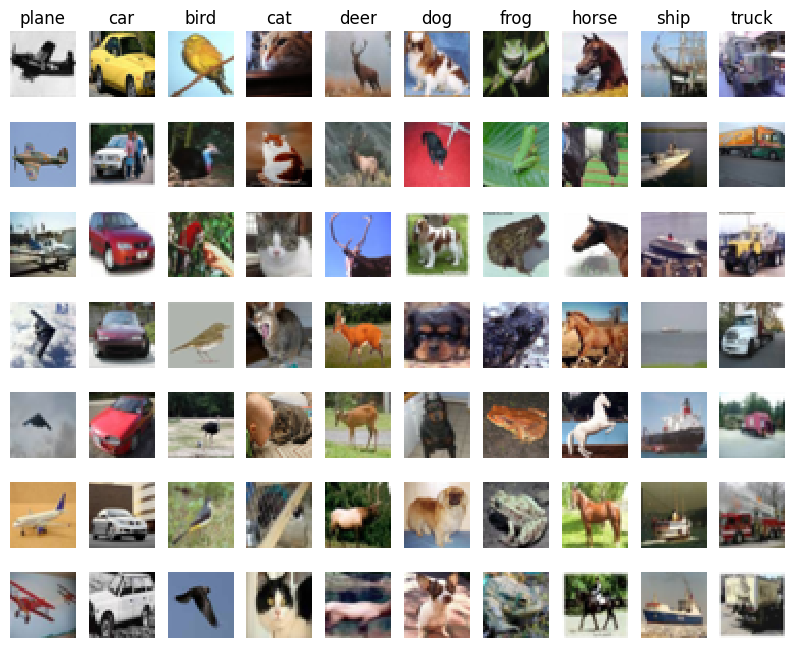

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


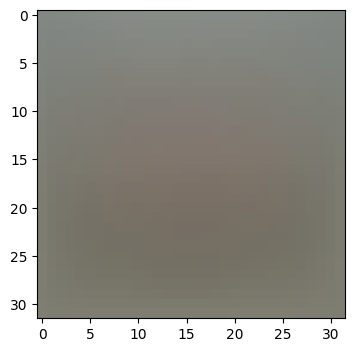

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [8]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.

As you can see, we have prefilled the function `softmax_loss_naive` which uses for loops to evaluate the softmax loss function.

In [43]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.softmax import softmax_loss_naive , softmax_loss_vectorized , softmax_loss_vectorized_slim
import time

# generate a random Softmax classifier weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.396149
loss: 2.396149
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ *Fill this in*

At the start of training, the model's weights are small and random, so it outputs nearly uniform probabilities across all 10 classes. That means the probability of the correct class is approximately (1  / num_classes) 0.1. The softmax loss is the negative log of this probability, so initially we expect:Loss=−log(0.1)≈2.30
Loss=−log(0.1)≈2.30

This represents random guessing before the model starts to learn meaningful patterns.

The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the softmax loss function and implement it inline inside the function `softmax_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [44]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 0.329765 analytic: 0.329765, relative error: 1.284802e-07
numerical: -0.739559 analytic: -0.739559, relative error: 2.744387e-08
numerical: -7.413187 analytic: -7.413187, relative error: 2.554673e-09
numerical: 3.600829 analytic: 3.600829, relative error: 1.180113e-08
numerical: -1.014905 analytic: -1.014905, relative error: 4.949102e-08
numerical: 0.387598 analytic: 0.387598, relative error: 2.332769e-07
numerical: -4.602113 analytic: -4.602113, relative error: 8.493984e-09
numerical: -1.257779 analytic: -1.257779, relative error: 2.385963e-08
numerical: -0.702350 analytic: -0.702350, relative error: 7.974177e-08
numerical: 0.697472 analytic: 0.697472, relative error: 2.077374e-08
numerical: -2.219694 analytic: -2.219694, relative error: 2.970465e-09
numerical: 0.012952 analytic: 0.012952, relative error: 4.474307e-06
numerical: -0.258906 analytic: -0.258906, relative error: 3.282735e-07
numerical: -4.232571 analytic: -4.232571, relative error: 4.343591e-09
numerical: 1.353

In [47]:
# Next implement the function softmax_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, _ = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 2.396149e+00 computed in 0.090242s
Vectorized loss: 2.396149e+00 computed in 0.018366s
difference: 0.000000


In [48]:
# Complete the implementation of softmax_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

_ , grad_vectorized_slim = softmax_loss_vectorized_slim(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.101342s
Vectorized loss and gradient: computed in 0.006912s
Vectorized loss and gradient: computed in 0.012952s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside `cs231n/classifiers/linear_classifier.py`.

In [54]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import Softmax
softmax = Softmax()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 777.045501
iteration 100 / 1500: loss 284.999538
iteration 200 / 1500: loss 105.685812
iteration 300 / 1500: loss 40.048933
iteration 400 / 1500: loss 16.011077
iteration 500 / 1500: loss 7.184154
iteration 600 / 1500: loss 4.004475
iteration 700 / 1500: loss 2.746168
iteration 800 / 1500: loss 2.308787
iteration 900 / 1500: loss 2.149951
iteration 1000 / 1500: loss 2.144978
iteration 1100 / 1500: loss 2.081251
iteration 1200 / 1500: loss 2.154732
iteration 1300 / 1500: loss 2.115744
iteration 1400 / 1500: loss 2.073050
That took 5.187754s


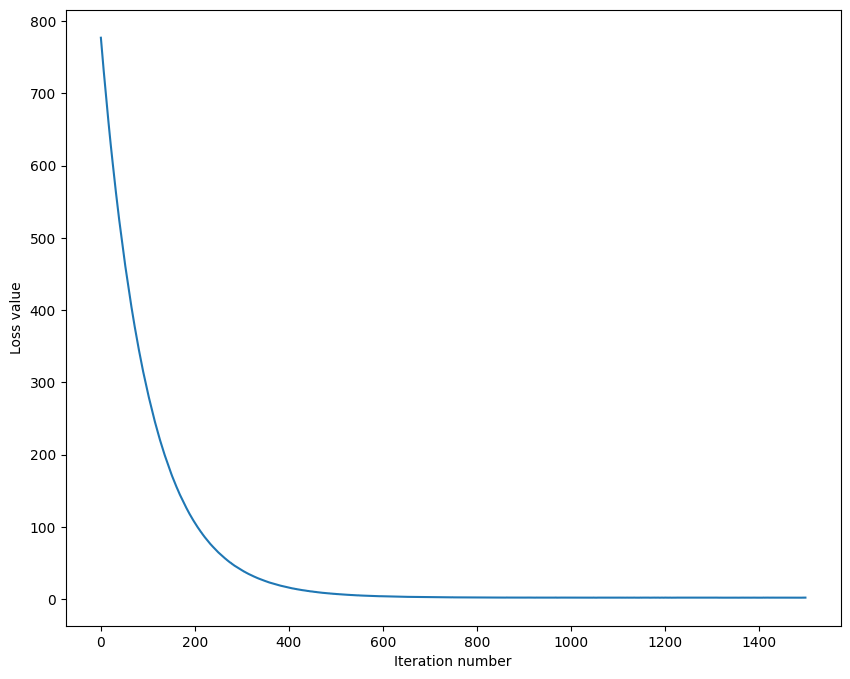

In [55]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [56]:
# Write the LinearClassifier.predict function and evaluate the performance on
# both the training and validation set
# You should get validation accuracy of about 0.34 (> 0.33).
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.333449
validation accuracy: 0.347000


In [57]:
# Save the trained model for autograder.
softmax.save("softmax.npy")

softmax.npy saved.


In [62]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.365 (> 0.36) on the validation set.

# Note: you may see runtime/overflow warnings during hyper-parameter search.
# This may be caused by extreme values, and is not a bug.

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.

results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_softmax = None # The Softmax object that achieved the highest validation rate.

################################################################################
# Code to tune hyperparameters and select the best model
################################################################################

# Try a range of learning rates and regularization strengths
learning_rates = [1e-7, 2e-7, 5e-7, 1e-6]  # Expanded search space
regularization_strengths = [1e4, 2.5e4, 5e4]  # Expanded search space

num_iters = 1500  # Set higher for final run, lower for debugging like 100

for lr in learning_rates:
    for reg in regularization_strengths:
        # Create a new Softmax instance for this combination
        softmax = Softmax()
        
        # Train the model
        loss_history = softmax.train(
            X_train, y_train,
            learning_rate=lr,
            reg=reg,
            num_iters=num_iters,
            batch_size=200,
            verbose=False
        )
        
        # Predict on training and validation sets
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        
        # Calculate accuracy
        train_accuracy = np.mean(y_train_pred == y_train)
        val_accuracy = np.mean(y_val_pred == y_val)
        
        # Store the results
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        
        # Keep track of the best model
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_softmax = softmax
        
        print(f"Trained with lr={lr}, reg={reg} -> "
              f"train_acc={train_accuracy:.4f}, val_acc={val_accuracy:.4f}")

################################################################################
# Print summary of results
################################################################################
print("\nSummary of all results:")
for (lr, reg), (train_acc, val_acc) in sorted(results.items()):
    print(f"lr={lr:.1e}, reg={reg:.1e} -> train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

print(f"\nBest validation accuracy achieved during cross-validation: {best_val:.4f}")


Trained with lr=1e-07, reg=10000.0 -> train_acc=0.3511, val_acc=0.3650
Trained with lr=1e-07, reg=25000.0 -> train_acc=0.3336, val_acc=0.3510
Trained with lr=1e-07, reg=50000.0 -> train_acc=0.3098, val_acc=0.3260
Trained with lr=2e-07, reg=10000.0 -> train_acc=0.3566, val_acc=0.3740
Trained with lr=2e-07, reg=25000.0 -> train_acc=0.3294, val_acc=0.3470
Trained with lr=2e-07, reg=50000.0 -> train_acc=0.3093, val_acc=0.3320
Trained with lr=5e-07, reg=10000.0 -> train_acc=0.3539, val_acc=0.3640
Trained with lr=5e-07, reg=25000.0 -> train_acc=0.3297, val_acc=0.3410
Trained with lr=5e-07, reg=50000.0 -> train_acc=0.3081, val_acc=0.3170
Trained with lr=1e-06, reg=10000.0 -> train_acc=0.3452, val_acc=0.3670
Trained with lr=1e-06, reg=25000.0 -> train_acc=0.3089, val_acc=0.3320
Trained with lr=1e-06, reg=50000.0 -> train_acc=0.3121, val_acc=0.3200

Summary of all results:
lr=1.0e-07, reg=1.0e+04 -> train_acc=0.3511, val_acc=0.3650
lr=1.0e-07, reg=2.5e+04 -> train_acc=0.3336, val_acc=0.3510
lr=

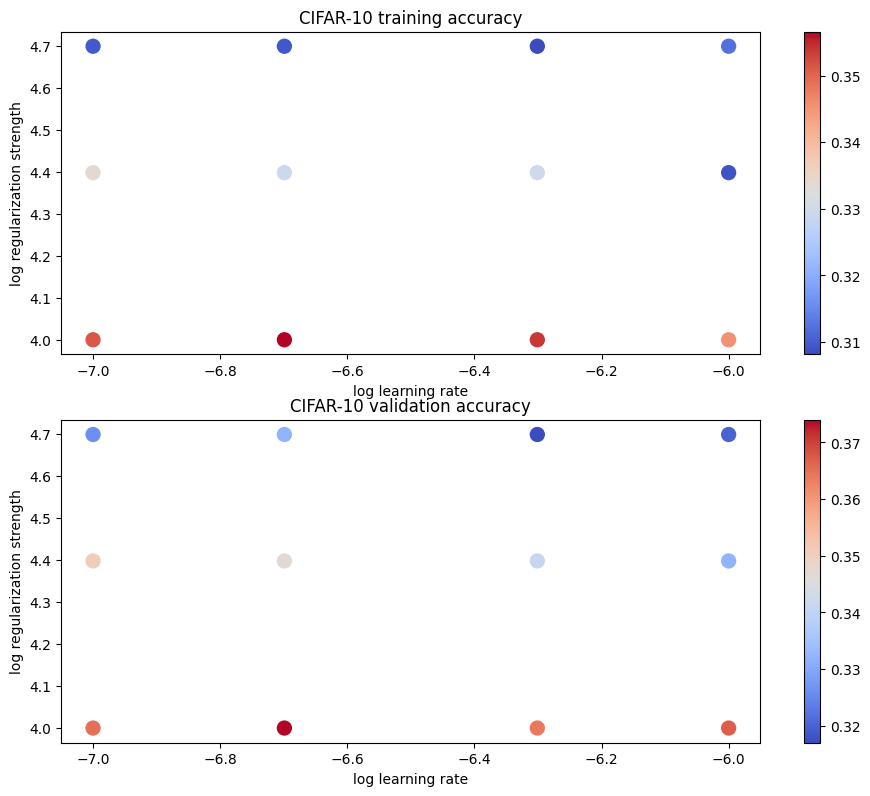

In [63]:
# Visualize the cross-validation results
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [64]:
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('Softmax classifier on raw pixels final test set accuracy: %f' % test_accuracy)

Softmax classifier on raw pixels final test set accuracy: 0.366000


In [65]:
# Save best softmax model
best_softmax.save("best_softmax.npy")

best_softmax.npy saved.


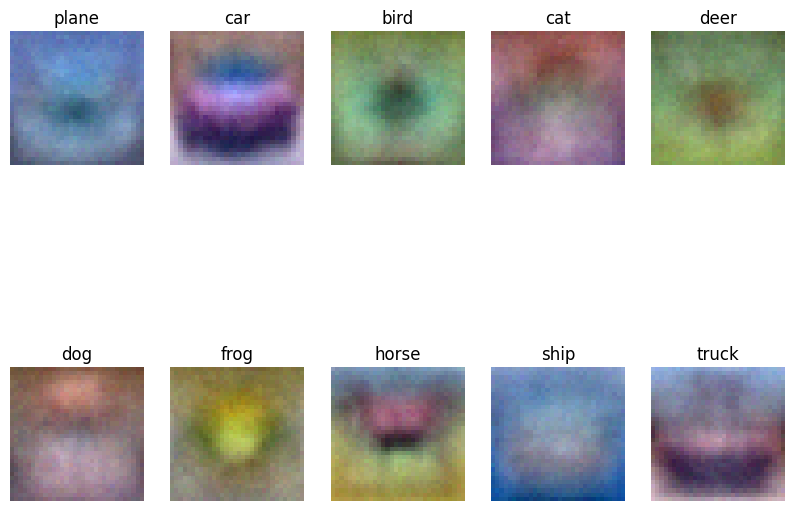

In [66]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 3**

Describe what your visualized Softmax classifier weights look like, and offer a brief explanation for why they look the way they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  

Each column of the weight matrix  𝑊 corresponds to a single class.

In softmax, the class scores are computed as:
𝑠 = 𝑋 ⋅ 𝑊

This means that each weight vector acts like a template or filter that tries to detect patterns in the input image for that class.

During training, the model adjusts these weights to increase the score of the correct class and decrease the others.

Because the data contains natural images, the learned weights tend to capture low-level visual patterns like edges, textures, and dominant colors.

These patterns are blurry because:

- The model is linear (no hidden layers), so it can't capture complex structures or sharp details.

- It aggregates information across many examples, which smooths out fine-grained features.

Summary:
The weights appear as fuzzy class prototypes — they reflect the average distinguishing features of each class, but lack detail because the softmax classifier is a simple linear model.